In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens


import sklearn.feature_selection as feature_selection

import pickle

In [2]:
age_clast_model = pickle.load(open('age_clast_model.mdl', 'rb'))

In [43]:
age_cls_model = pickle.load(open('age_cls_model.mdl', 'rb'))

In [46]:
age_reg_model = pickle.load(open('age_reg_mogel.mdl', 'rb'))

#### Plotting Helper functions

In [3]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for model training

In [4]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

### Import data

In [5]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

In [6]:
data_test = data_test.fillna(value={'Fare':0})

In [7]:
#Concatinate train & test data (to make sure that all unique titles are captured)
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [8]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

In [9]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    data['ttl'] = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    data['ttl'] = data['ttl'].apply(lambda i: mask[i])
    return data

In [10]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

In [11]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [12]:
# Clean ticket ID from all punctuation and spaces
df_fam = data_tot.copy()
df_fam['Ticket'] = df_fam['Ticket'].apply(lambda i: clean_text(i))

In [13]:
families0 = df_fam.loc[(df_fam['SibSp']>0) & (df_fam['Parch']==0)]
families1 = df_fam.loc[df_fam['Parch']>0]
singles = df_fam.loc[(df_fam['SibSp']==0) & (df_fam['Parch']==0)]

In [14]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [15]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

In [16]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [17]:
# Make a mask of family groups labels
fgrp_mask = {}
for idx, grp in enumerate(fam_grps):
    for pid in grp['PassengerId']:
        fgrp_mask[pid] = idx

In [18]:
# Make a mask of ticket fare
fare_mask = {}
for tic in df_fam['Ticket'].unique():
    # subgroup with matching tickets
    tic_grp = df_fam.loc[df_fam['Ticket']==tic]
    
    # passenger class that the subgroup belongs to
    c = tic_grp['Pclass'].values[0]
    
    # ticket fare of the subgroup
    # all subgroup members have the same ticket fare initially
    fare_grp = tic_grp['Fare'].values[0]
    
    # if a subgroup fare is 0 then assign a mean of the fare of the Pclass that the subgroup belongs to
    if (fare_grp == 0) or (fare_grp is None):
        fare_i = np.mean(df_fam.loc[df_fam['Pclass']==c, 'Fare'])
        for pid in tic_grp['PassengerId']:
            fare_mask[pid] = fare_i

    # recalculate fare for subrgoup members: fare_i = group_fare / n_members
    if len(tic_grp.index) > 1:
        if fare_grp > 0:
            
            if np.mean(tic_grp['Fare'])==fare_grp: #check if all group members have same fare
                fare_i = fare_grp / len(tic_grp.index)
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = fare_i
            else:
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = tic_grp.loc[tic_grp['PassengerId']==pid, 'Fare'].values[0]
    # keep fare value for passengers with unuque tickets
    else:
        if fare_grp > 0:
            fare_i = fare_grp
            for pid in tic_grp['PassengerId']:
                fare_mask[pid] = fare_i

In [19]:
# Make a mask of ticket codes
m_tickets = []
for tic in df_fam['Ticket'].unique():
    if len(df_fam.loc[df_fam['Ticket']==tic].index) > 1:
        m_tickets.append(tic)

ticket_mask = {}        
for pid in df_fam['PassengerId']:
    tic = df_fam.loc[df_fam['PassengerId']==pid, 'Ticket'].values[0]
    if tic in m_tickets:
        ticket_mask[pid] = m_tickets.index(tic) + 1
    else:
        ticket_mask[pid] = 0

In [20]:
# Encode family groups
# This function adds new class variable 'fgrp' that indicates a group that a passenger belongs to.
def family_groups_encoder(data, fgrp_mask):
    data['fgrp'] = data['PassengerId'].apply(lambda i: fgrp_mask[i])
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, fare_mask):
    data['Fare'] = data['PassengerId'].apply(lambda i: fare_mask[i])
    return data

# Encode tickets
def ticket_encoder(data, ticket_mask):
    data['Ticket'] = data['PassengerId'].apply(lambda i: ticket_mask[i])
    return data

In [21]:
# Log-transform 'Fare'
def fare_transformer(data):
    data['Fare'] = data['Fare'].apply(np.log)
    return data

In [34]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

# Add 'Family size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
    data['famsize'] = data['famsize'].apply(lambda i: i if i<8 else 8)
    return data

#Encoding 'Pclass' (to labels 0,1,2)
def pclass_encoder(data):
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

def cabin_encoder(data):
    data = data.fillna(value={'Cabin': 0})
    data['Cabin'] = data['Cabin'].apply(lambda i: 1 if i!=0 else 0)
    return data

In [23]:
def age_transformer(data, model):
    data['Age_trans'] = data['Age'].apply(np.log)
    X = data['Age_trans'].to_frame()
    data['Age_cls'] = model.predict(X)
    data['Age_cls'] = data['Age_cls'].astype(int)
    return data

### Predict missing missing values for age

In [37]:
data = family_groups_encoder(data_tot.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[data['Age'].notna()].copy()
data = age_transformer(data, age_clast_model)
data = cabin_encoder(data)

data = data[['Age', 'Age_cls', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

In [39]:
data.head()

,Age,Age_cls,Fare,Sex,ttl,fgrp,famsize,Ticket,Pclass,Embarked,Cabin
0,22.0,2,1.981001,0,1,2,1,0,2,1,0
1,38.0,0,3.573515,1,2,3,1,1,0,0,1
2,26.0,2,2.070022,1,3,0,0,0,2,1,0
3,35.0,0,3.279030,1,2,3,1,2,0,1,1
4,35.0,0,2.085672,0,1,0,0,0,2,1,0


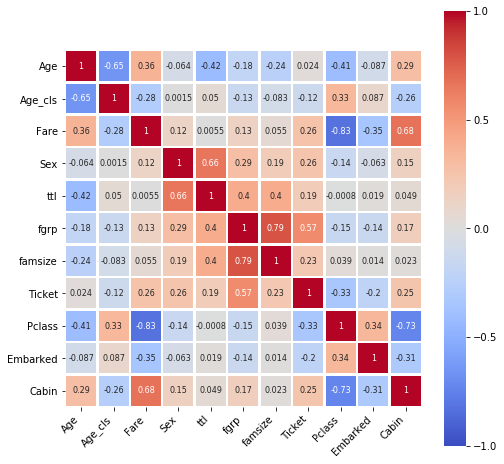

In [40]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [41]:
#Age encoder (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_model):
    cols = ['Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']

    data_na = data[data['Age'].isnull()].copy()
    data_notna = data[data['Age'].notna()].copy()

    # transform non-null age values
    data_notna['Age'] = data_notna['Age'].apply(np.log)

    # predict class labels
    X = data_na[cols].copy()
    X['Age_cls'] = age_cls_model.predict(X)

    # predict age
    data_na['Age'] = age_reg_model.predict(X)
    return pd.concat([data_na, data_notna])

## Predict survivals

#### Preprocessind data

In [107]:
data = family_groups_encoder(data_train.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = age_predictor(data, age_cls_model, age_reg_model)
data = cabin_encoder(data)

data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

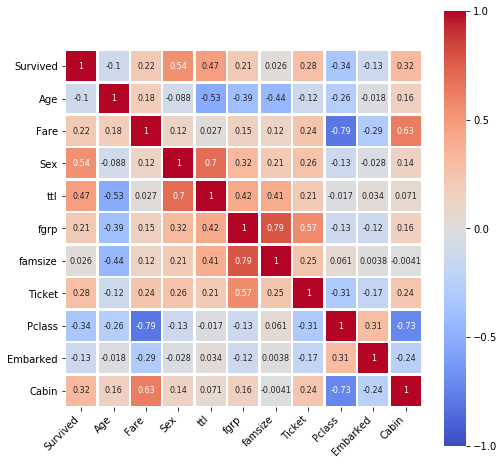

In [49]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.drop(columns='PassengerId').corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train base estimators for stacking model

In [108]:
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

In [51]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'roc_auc'

In [52]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [53]:
base_scores = {}

#### LinearDiscriminantAnalysis

In [54]:
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cv_rep(lda, X, y, cv, scoring)
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.807615  0.872040         0.819255
std_train            0.012528  0.013794         0.012715
mean_test            0.788788  0.866826         0.803578
std_test             0.023967  0.024306         0.022079


In [55]:
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### QuadraticDiscriminantAnalysis

In [56]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.08989795918367348)
scores = cv_rep(qda, X, y, cv, scoring)
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.814311  0.865152         0.819687
std_train            0.011014  0.012696         0.012076
mean_test            0.794928  0.854039         0.802072
std_test             0.025749  0.024278         0.025424


In [57]:
param_ranges = {'reg_param': np.linspace(0.001,0.1,99)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.817324  0.868199         0.820467
std_train            0.017136  0.012280         0.012651
mean_test            0.799553  0.854416         0.803706
std_test             0.025079  0.024291         0.025017
{'reg_param': 0.043428571428571434}


In [58]:
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### AdaBoostClassifier

In [59]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', 
                             learning_rate=0.07776923076923077,
                             n_estimators=65,
                             random_state=random_state)
scores = cv_rep(abc, X, y, cv, scoring)
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818144  0.877052         0.832249
std_train            0.011406  0.011843         0.010686
mean_test            0.802977  0.865281         0.820289
std_test             0.022017  0.023923         0.021755


In [60]:
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.5, 40)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818144  0.877754         0.832249
std_train            0.011406  0.011882         0.010686
mean_test            0.802977  0.866040         0.820289
std_test             0.022017  0.022915         0.021755
{'learning_rate': 0.11615384615384615, 'n_estimators': 45}


In [61]:
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

Optimal number of features : 4
Features to drop: 

['Age', 'Fare', 'Sex', 'fgrp', 'Ticket', 'Embarked']


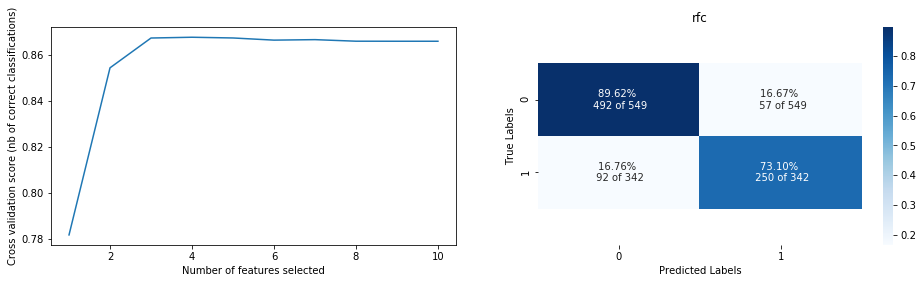

In [110]:
rfecv = feature_selection.RFECV(estimator=abc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(abc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

#### ExtraTreesClassifier

In [62]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               n_estimators=75,
                               max_depth=5,
                               ccp_alpha=0.0)
scores = cv_rep(etc, X, y, cv, scoring)
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.827370  0.911878         0.842307
std_train            0.009750  0.010449         0.007890
mean_test            0.792180  0.871339         0.810335
std_test             0.028262  0.025923         0.027323


In [63]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(60, 100, 5),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.909005  0.912528         0.930606
std_train            0.010499  0.010503         0.009223
mean_test            0.794907  0.871545         0.815629
std_test             0.024304  0.025271         0.021616
{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 95}


In [64]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 60)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818512  0.910627         0.831673
std_train            0.011106  0.010698         0.010414
mean_test            0.794484  0.872551         0.813527
std_test             0.025469  0.024146         0.024457
{'ccp_alpha': 0.0014576271186440678}


In [65]:
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

Optimal number of features : 10
Features to drop: 

[]


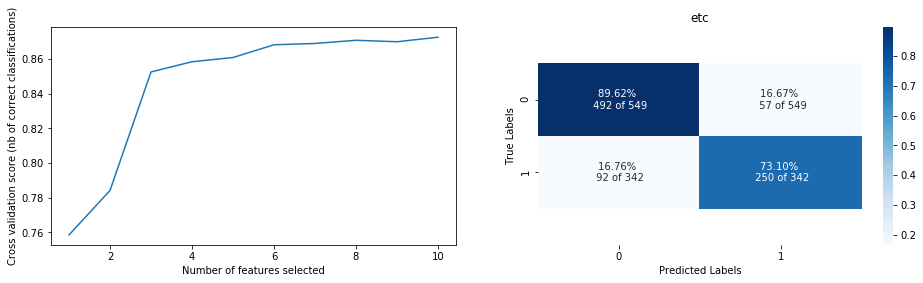

In [111]:
rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='etc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

#### RandomForestClassifier

In [66]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=20,
                                 max_depth=5,
                                 ccp_alpha=0.04)
scores = cv_rep(rfc, X, y, cv, scoring)
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.804392  0.866046         0.814882
std_train            0.015038  0.013754         0.016265
mean_test            0.783510  0.854084         0.799136
std_test             0.024070  0.020979         0.024837


In [67]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(5, 100, 10),
                'max_depth': np.arange(3, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.808011  0.869659         0.820342
std_train            0.014887  0.015181         0.013507
mean_test            0.787573  0.859785         0.805030
std_test             0.023983  0.020490         0.028386
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 75}


In [68]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.1, 60)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.919253  0.970821         0.867304
std_train            0.012968  0.004977         0.010112
mean_test            0.806555  0.877864         0.829354
std_test             0.024678  0.017530         0.019334
{'ccp_alpha': 0.004355932203389831}


In [69]:
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### LogisticRegression

In [70]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3122448979591839)
scores = cv_rep(lr, X, y, cv, scoring)
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.813537  0.873383         0.804726
std_train            0.013761  0.013797         0.013164
mean_test            0.804537  0.866955         0.799854
std_test             0.030378  0.023780         0.025794


In [71]:
param_ranges = {'C': np.linspace(0.01, 5, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.814177  0.871911         0.805292
std_train            0.013960  0.013969         0.013454
mean_test            0.807690  0.868914         0.802767
std_test             0.028394  0.023263         0.024869
{'C': 0.31551020408163266, 'solver': 'liblinear'}


c:\00_data\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


In [72]:
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RidgeClassifier

In [73]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.122448979591837)
scores = cv_rep(rc, X, y, cv, scoring)
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.810191  0.871425         0.810665
std_train            0.013631  0.014099         0.013701
mean_test            0.799606  0.866214         0.802103
std_test             0.026531  0.023178         0.022123


In [74]:
param_ranges = {'alpha': np.linspace(1, 45, 99)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.812078  0.870724         0.813072
std_train            0.013548  0.013991         0.012691
mean_test            0.799362  0.866478         0.802593
std_test             0.025927  0.023037         0.021839
{'alpha': 15.36734693877551}


In [75]:
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### SVC

In [76]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=9428.57142857143)
scores = cv_rep(svc, X, y, cv, scoring)
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.830879  0.890418         0.829975
std_train            0.015561  0.015279         0.019758
mean_test            0.789723  0.841265         0.790808
std_test             0.022417  0.029110         0.024658


In [77]:
param_ranges = {'C': np.linspace(400, 1000, 23)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.817262  0.873950         0.822992
std_train            0.014120  0.014095         0.014786
mean_test            0.796440  0.856046         0.805791
std_test             0.023526  0.018530         0.023919
{'C': 400.0}


In [78]:
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [79]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
                 nu=0.5102089795918366)
scores = cv_rep(nusvc, X, y, cv, scoring)
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.813949  0.861710         0.825877
std_train            0.010865  0.010086         0.010184
mean_test            0.791395  0.844342         0.807660
std_test             0.021231  0.016590         0.020095


In [80]:
param_ranges = {'nu': np.linspace(0.1,0.5,99)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.815713  0.863030         0.828439
std_train            0.011818  0.010674         0.013107
mean_test            0.795034  0.851115         0.811121
std_test             0.021847  0.020957         0.021006
{'nu': 0.49591836734693884}


In [81]:
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### Base estimators scores

In [82]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,rfc,etc,lr,lda,rc,abc,svc,qda,nusvc
test_score,0.877864,0.872551,0.868914,0.866826,0.866478,0.866040,0.856046,0.854416,0.851115
train_score,0.970821,0.910627,0.871911,0.872040,0.870724,0.877754,0.873950,0.868199,0.863030


In [83]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc}

In [84]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

c:\00_data\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


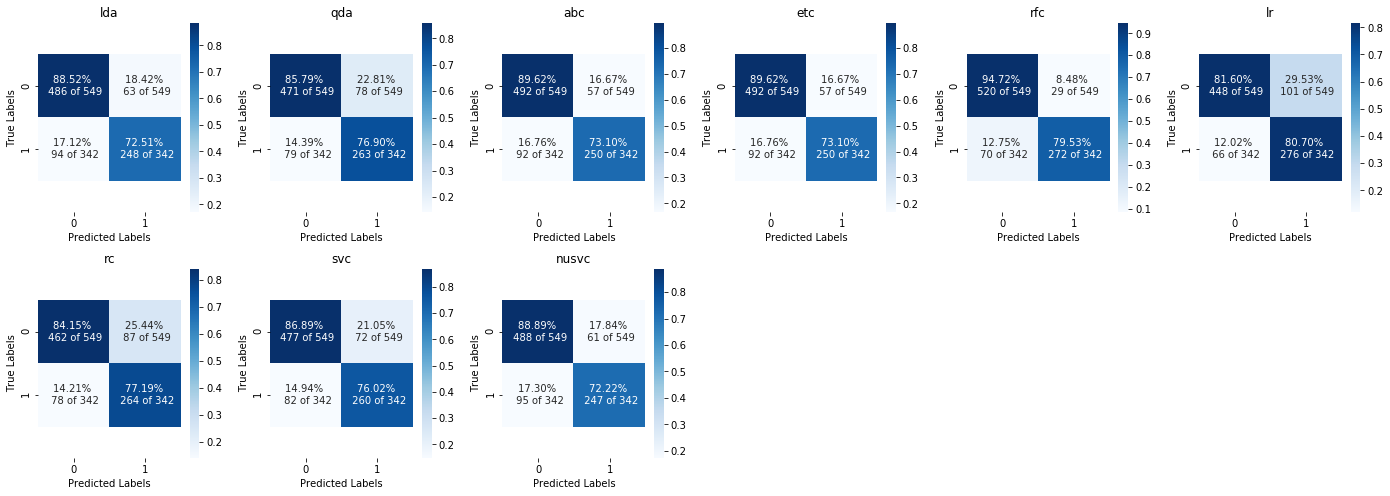

In [85]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [86]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [87]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

#### Base estimators correlation matrix

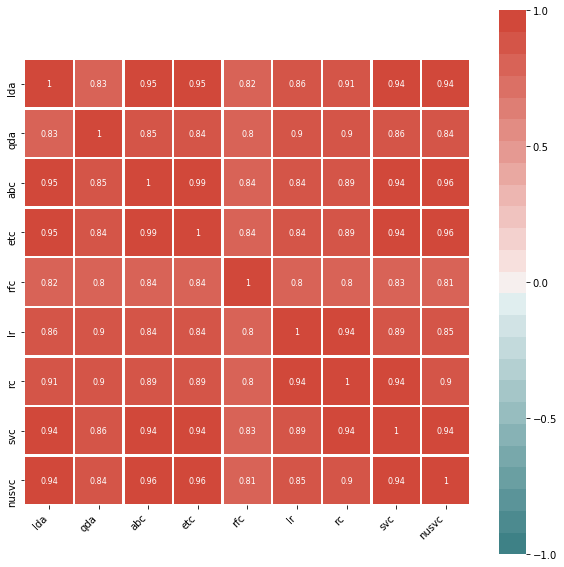

In [88]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [89]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,svc,abc,etc,nusvc,lda,rc,lr,qda,rfc
cc,0.807341,0.80653,0.805991,0.801196,0.800222,0.797399,0.768398,0.758923,0.726867


#### Select less correlated models

In [90]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rc':rc,'svc':svc}

In [91]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

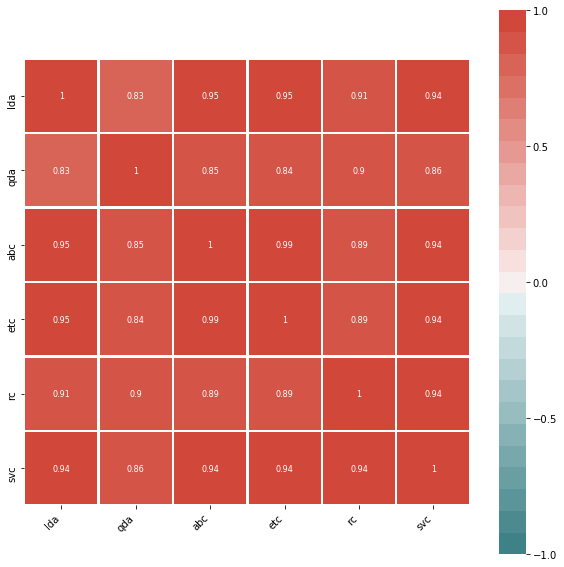

In [92]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [93]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,abc,etc,svc,lda,rc,qda
cc,0.769812,0.769002,0.768084,0.763798,0.755854,0.714075


#### Compare stacking classifier score for different final estimator models

In [94]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    fin_models = []
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = [res.loc['mean_test', score], res.loc['mean_train', score]]
        fin_models.append((m[0], model_st))
    scores = pd.DataFrame(scores, index=['Test_score', 'Train_score']).sort_values(by='Test_score', axis=1,ascending=False)
    return fin_models, scores

In [95]:
final_models_surv = [('abc', ens.AdaBoostClassifier()),
                     ('etc', ens.ExtraTreesClassifier()),
                     ('rfc', ens.RandomForestClassifier()),
                     ('lr', lm.LogisticRegression()),
                     ('svc', svm.SVC())]

In [96]:
fin_models, scores = train_final_models(final_models_surv, X, y, cv_folds=5, score=refit)

In [97]:
scores

,lr,abc,rfc,etc,svc
Test_score,0.820056,0.818188,0.814716,0.813407,0.805152
Train_score,0.843088,0.840660,0.841676,0.840336,0.835404


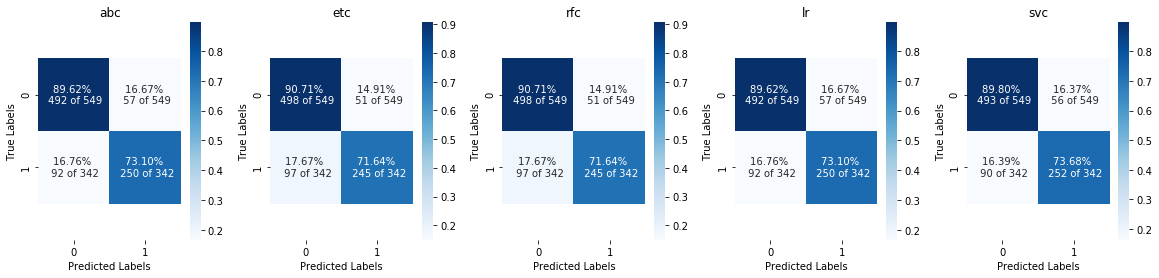

In [98]:
grd_n = len(fin_models)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

#### Train stacking classifier

In [109]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.824295,0.840660,0.838966
std_train,0.008834,0.014302,0.006335
mean_test,0.801221,0.818188,0.817513
std_test,0.021799,0.026663,0.023105


In [100]:
param_ranges = {'final_estimator__n_estimators': np.arange(50, 120, 10), 'final_estimator__learning_rate': np.linspace(0.1, 0.8, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.824507  0.841503         0.839633
std_train            0.009124  0.013682         0.007448
mean_test            0.803283  0.820012         0.819141
std_test             0.021927  0.028640         0.022600
{'final_estimator__learning_rate': 0.6157894736842106, 'final_estimator__n_estimators': 80}


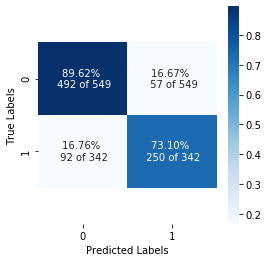

In [101]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

## Predict test set

#### Preprocessind data

In [103]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)

data = age_predictor(data, age_cls_model, age_reg_model)
data = cabin_encoder(data)
data = data[['PassengerId', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

#### Make predictions

In [104]:
X = data.drop(columns=['PassengerId'])

In [105]:
data['Survived'] = model_st.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("df_submission.csv", index=False)